In [19]:
import pandas as pd
import numpy as np
import os


# 读取各文件的前100万行
# 读取数据文件
orders = pd.read_csv('data/instacart/orders.csv',nrows=1000000,)
order_products = pd.read_csv('data/instacart/order_products__prior.csv',nrows=1000000)
products = pd.read_csv('data/instacart/products.csv',nrows=1000000)
aisles = pd.read_csv('data/instacart/aisles.csv',nrows=1000000)

# 合并数据
merged_data = order_products.merge(orders, on='order_id', how='left')
merged_data = merged_data.merge(products, on='product_id', how='left')
merged_data = merged_data.merge(aisles, on='aisle_id', how='left')


# 统计缺失数与缺失率
print(merged_data.info())
merged_data.isnull().sum()/merged_data.shape[0]  #数据缺失率，没有缺失值

# 使用user_id和aisle_id构建交叉表
cross_tab = pd.crosstab(merged_data['user_id'], merged_data['aisle_id'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 14 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   order_id                1000000 non-null  int64  
 1   product_id              1000000 non-null  int64  
 2   add_to_cart_order       1000000 non-null  int64  
 3   reordered               1000000 non-null  int64  
 4   user_id                 290884 non-null   float64
 5   eval_set                290884 non-null   object 
 6   order_number            290884 non-null   float64
 7   order_dow               290884 non-null   float64
 8   order_hour_of_day       290884 non-null   float64
 9   days_since_prior_order  272118 non-null   float64
 10  product_name            1000000 non-null  object 
 11  aisle_id                1000000 non-null  int64  
 12  department_id           1000000 non-null  int64  
 13  aisle                   1000000 non-null  object 
dtypes: 

In [20]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# 使用PCA降维，保留90%的方差
pca = PCA(n_components=0.85)
pca_result = pca.fit_transform(cross_tab)

print(f"原始数据维度: {cross_tab.shape}")
print(f"PCA降维后维度: {pca_result.shape}")
print(f"保留的方差比例: {sum(pca.explained_variance_ratio_):.4f}")


原始数据维度: (19477, 134)
PCA降维后维度: (19477, 36)
保留的方差比例: 0.8507


In [21]:

# 定义KMeans聚类参数网格，n_clusters是聚类数量，init是初始化方法，n_init是初始化次数
param_grid = {
    'n_clusters': range(2, 9),
}

# 初始化KMeans模型
kmeans = KMeans(random_state=42)

# 使用不同参数组合训练模型并计算轮廓系数
best_score = -1
best_params = None

for n_clusters in param_grid['n_clusters']:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_result)
            
    # 计算轮廓系数
    score = silhouette_score(pca_result, cluster_labels)
    # 更新最佳参数
    if score > best_score:
            best_score = score
            best_params = {'n_clusters': n_clusters}

# 输出最佳参数
print("\n最佳聚类参数:")
print(f"最佳轮廓系数: {best_score:.4f}")
print(f"最佳参数: {best_params}")


最佳聚类参数:
最佳轮廓系数: 0.4425
最佳参数: {'n_clusters': 2}


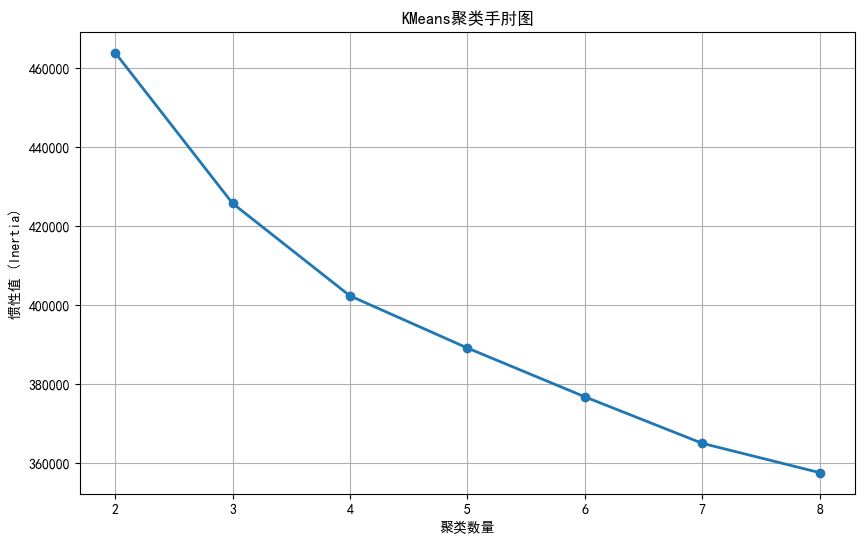

In [25]:
# 设置中文字体，解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

# 计算不同聚类数量下的惯性（inertia）值，用于绘制手肘图
inertia_values = []
cluster_range = param_grid['n_clusters']

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pca_result)
    inertia_values.append(kmeans.inertia_)

# 绘制手肘图
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, 'o-', linewidth=2)
plt.grid(True)
plt.xlabel('聚类数量')
plt.ylabel('惯性值 (Inertia)')
plt.title('KMeans聚类手肘图')
plt.xticks(cluster_range)
plt.show()


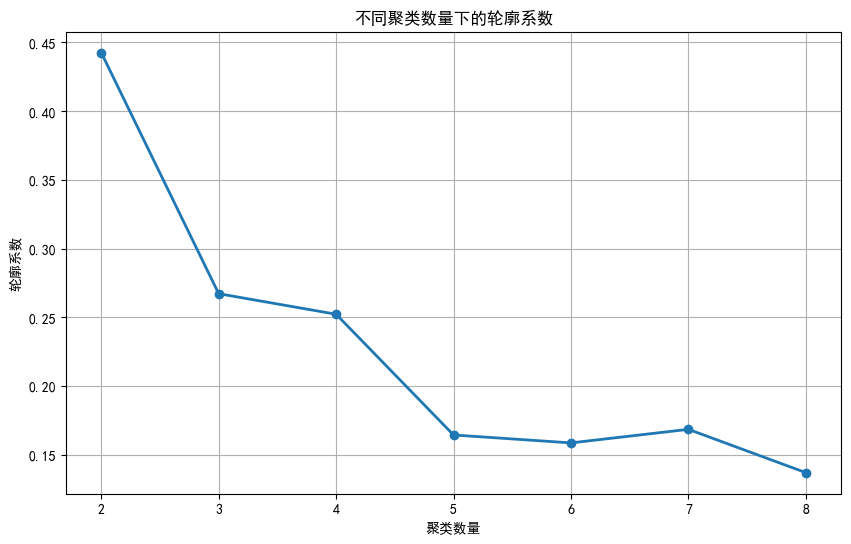

In [24]:

# 使用最佳参数训练最终模型
best_kmeans = KMeans(
    n_clusters=best_params['n_clusters'],
    random_state=42
)
cluster_labels = best_kmeans.fit_predict(pca_result)
# 将聚类标签添加到原始数据中
df_clustered = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
df_clustered['cluster'] = cluster_labels


# 绘制不同聚类数量下的轮廓系数折线图
silhouette_scores = []
cluster_range = param_grid['n_clusters']

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_result)
    score = silhouette_score(pca_result, cluster_labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, 'o-', linewidth=2)
plt.grid(True)
plt.xlabel('聚类数量')
plt.ylabel('轮廓系数')
plt.title('不同聚类数量下的轮廓系数')
plt.xticks(cluster_range)
plt.show()

